# Team 2: InceptionV3 Progress Check
We've developed a baseline model using InceptionV3 using Tensorflow as well as a model based on DenseNet to be used as a reference model.

For this sample, we utilized which is a subset of the [Imagenet dataset](http://www.image-net.org/update-mar-11-2021.php). Imagenet itself has over 15 million images with 1000 class labels. Because of its sheer magnitude, we chose Tiny Imagenet which has 100,000 training images with 200 class labels over this.

## What is DenseNet & Why Did We Choose It as a Reference Model?
Since another case study team is actually implementing ResNet/ResNext or a variant of that architecture, we chose DenseNet. InceptionV3's main feature is its ability to reduce the overall number of parameters; and as a result, reduce the computational demand of training a model. 

DenseNet also known as "Densely Connected Convolutional Network" has each layer in the network receive inputs from all layers preceding it and are combined using channel-wise concatenation. 

![image.png](Images/densenet1.png)


Since each layer receives information from all preceding layers, there's minimal information bottleneck; allowing the overall model to be much smaller. 

![image-2.png](Images/densenet2.png)

An example of forward propagation is shown here:

![image-3.png](Images/densenet3.png)


The original input $x_{0}$ is passed through the first layer to obtain an output $x_{1}$. $x_{0}$ and $x_{1}$ are then concatenated channel-wise and passed onto the next layer where the same process is repeated over and over.

As the network grows in size (layers), the input for layers deeper in the network grows massive. 

![image-4.png](Images/densenet4.png)


There is a composite layer which also acts as a bottleneck-reducing layer by dimension reducing using a 1x1 filter. 

Combining all of these things, a fully connected DenseNet model may look like:

![image-5.png](Images/densenet5.png)

InceptionV3 and DenseNet both focus primarily on reducing the overall number of parameters used by the network but maintains relatively high accuracy by reducing the "diminshing gradient" problem that's present in large neural networks.

## What Does the Data Look Like?
Each image in Tiny Imagenet is 64x64x3 representing the width, height, and RGB channels.

First import necessary libraries and packages. Some imports are unneeded but were used for testing and development.

In [3]:
# Utility imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Tensorflow/Keras Imports
import tensorflow 
from keras.utils import Sequence, to_categorical
from keras import callbacks
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet121, InceptionV3
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers
from numpy import save

import warnings
warnings.filterwarnings("ignore")

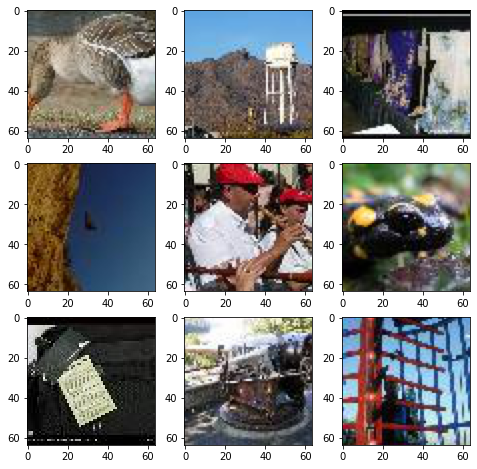

In [17]:
base_path = "./tiny-imagenet-200"
path_to_imgs = f"{base_path}/test/images"
img_names = os.listdir(f"{base_path}/test/images")[:9] 

fig = plt.figure(figsize=(8,8))
w, h = 10, 10
cols, rows = 3, 3

for i in range(0, cols * rows):
    img = mpimg.imread(f"{path_to_imgs}/{img_names[i]}")
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img)

The images are very low resolution as mentioned previously (64 x 64 pixels). 

Next we'll create and train baseline models for both InceptionV3 and DenseNet using TensorFlow.

### InceptionV3 Sample Implementation
Some code will be reused between both models.

In [35]:
seed=0
target_img_size=(224, 224) # 224x244 can be changed to any dimension we want. 

In [44]:
# A shape of (None, None, 3) means that width and height can be anything. '3' signifies the RGB channels.
# Using a pre-trained baseline model from Keras
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(None, None, 3))
x = inception_base.output
x = GlobalAveragePooling2D()(x) # Reduce number of parameters overall to minimize overfitting.
x = Dense(1024, activation='relu')(x)
# Output layer: 200 classes
predictions = Dense(200, activation='softmax')(x)
model = Model(inputs=inception_base.input, outputs=predictions)

# Train only the top layers which were randomly initialized. Freeze convolutional Inception layers
for layer in inception_base.layers:
    layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
             metrics=['accuracy'])
#print(model.summary())

For purposes of space, the summary of the model has been excluded. 
Here are the main statistics from the model.\
Total params: 24,105,960\
Trainable params: 2,303,176\
Non-trainable params: 21,802,784

### Data Pipeline For Local Training
We're currently working on refactoring to utilize Azure Pipelines with Compute Clusters. Since that portion is not presentation-ready, we're showcasing a local training example for both models.

In [30]:
#1, 2, 3, 4 are temporary column names. These aren't needed and are dropped.
val_data = pd.read_csv(f"{base_path}/val/val_annotations.txt", sep="\t", 
                      header=None, names=['file', 'class', '1', '2', '3', '4'])
val_data.drop(['1', '2', '3', '4'], axis=1, inplace=True)
print(val_data.head())

         file      class
0  val_0.JPEG  n03444034
1  val_1.JPEG  n04067472
2  val_2.JPEG  n04070727
3  val_3.JPEG  n02808440
4  val_4.JPEG  n02808440


Each file corresponds with a ID (e.g. n03444034). This corresponds with a human-readable label that's located in another file.

In [31]:
# Normalize each RGB value. RGB values = 0 to 255 (inclusive). 
# Converts to a floating point between 0.0 and 1.0 inclusive.
train_datagen, valid_datagen = ImageDataGenerator(rescale=1.0/255), ImageDataGenerator(rescale=1.0/255)

In [40]:
train_data_generator = train_datagen.flow_from_directory(f"{base_path}/train/",
                            target_size=target_img_size, color_mode="rgb", 
                            batch_size=32, class_mode="categorical", 
                            shuffle=True, seed=seed)
validation_data_generator = valid_datagen.flow_from_dataframe(val_data, 
                            directory = f"{base_path}/val/images", 
                            x_col="file", y_col="class",
                            target_size=target_img_size, color_mode="rgb",
                            class_mode ="categorical", batch_size=32,
                            shuffle=True, seed=seed)

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


In [43]:
earlystop = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5,
                                    restore_best_weights=True)
model.fit(train_data_generator, epochs=15, steps_per_epoch=200,
                    validation_steps=200,
                    validation_data=validation_data_generator, verbose=1,
                    callbacks=[earlystop])
model.save("./models/inceptionv3_0.1.h5")

Epoch 1/15
200/200 [==============================] - 153s 755ms/step - loss: 4.8948 - accuracy: 0.1406 - val_loss: 2.6078 - val_accuracy: 0.4313
Epoch 2/15
200/200 [==============================] - 151s 758ms/step - loss: 2.3165 - accuracy: 0.4788 - val_loss: 2.1569 - val_accuracy: 0.5064
Epoch 3/15
200/200 [==============================] - 157s 788ms/step - loss: 2.0659 - accuracy: 0.5278 - val_loss: 2.1319 - val_accuracy: 0.5250
Epoch 4/15
200/200 [==============================] - 159s 797ms/step - loss: 2.0169 - accuracy: 0.5438 - val_loss: 2.0972 - val_accuracy: 0.5206
Epoch 5/15
200/200 [==============================] - 157s 789ms/step - loss: 1.9183 - accuracy: 0.5575 - val_loss: 2.0133 - val_accuracy: 0.5525
Epoch 6/15
200/200 [==============================] - 154s 770ms/step - loss: 1.8731 - accuracy: 0.5678 - val_loss: 1.9417 - val_accuracy: 0.5667
Epoch 7/15
200/200 [==============================] - 154s 774ms/step - loss: 1.9055 - accuracy: 0.5728 - val_loss: 2.0109 -

### DenseNet
Will be utilizing the same seed so the DenseNet model should be utilizing the same shuffled training and testing batches for direct comparison

In [55]:
dense_base = DenseNet121(weights="imagenet", include_top=False,
                    input_shape=(None, None, 3)) # (None, None, 3) = Can accept any input size
x= dense_base.output
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(200,activation='softmax')(x) #FC-layer
model=Model(inputs=dense_base.input,outputs=preds)

# Freeze layers except last 8
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])
#print(model.summary())

Similarly, the output of the summary is too long for a report. Here are the main statistics:\
Total params: 8,720,648\
Trainable params: 1,680,072\
Non-trainable params: 7,040,576

Much fewer parameters than InceptionV3.

Since both models are using the same dataset, the data generators can be reused. They also share the same seeded values so both models would be trained the exact same way.

In [54]:
model.fit_generator(train_data_generator, epochs=15, steps_per_epoch=200,
                    validation_steps=200,
                    validation_data=validation_data_generator, verbose=1,
                    callbacks=[earlystop])
model.save("./models/densenet_0.1.h5")

Epoch 1/15
200/200 [==============================] - 310s 2s/step - loss: 5.4758 - accuracy: 0.0503 - val_loss: 3.3192 - val_accuracy: 0.2703
Epoch 2/15
200/200 [==============================] - 307s 2s/step - loss: 3.7310 - accuracy: 0.1952 - val_loss: 2.7868 - val_accuracy: 0.3494
Epoch 3/15
200/200 [==============================] - 308s 2s/step - loss: 3.3450 - accuracy: 0.2598 - val_loss: 2.5182 - val_accuracy: 0.4006
Epoch 4/15
200/200 [==============================] - 310s 2s/step - loss: 3.1205 - accuracy: 0.2869 - val_loss: 2.3951 - val_accuracy: 0.4219
Epoch 5/15
200/200 [==============================] - 308s 2s/step - loss: 3.0216 - accuracy: 0.3099 - val_loss: 2.3717 - val_accuracy: 0.4263
Epoch 6/15
200/200 [==============================] - 310s 2s/step - loss: 2.9668 - accuracy: 0.3214 - val_loss: 2.3145 - val_accuracy: 0.4367
Epoch 7/15
200/200 [==============================] - 310s 2s/step - loss: 2.8627 - accuracy: 0.3400 - val_loss: 2.2452 - val_accuracy: 0.4486

Seems that validation accuracy is higher than training accuracy suggesting overfitting. May be a result of using dropout layers. Testing this on another sample with image sizes of 96x96, an accuracy rate of ~0.48 was achieved. 

To note, training time took significantly longer for DenseNet despite using far fewer parameters. This may be a result of the intermediary layers that are used to help reduce the number of parameters in deeper layer of the network.

### Next Steps
We're currently working on fine-tuning the models as well as utilizing Azure Pipeline for our training.